# Generate results

results/
    generate_results/
        PBS/
            warehouse_1/
                throughput.npy (different number of agents)
                runtime.npy (different number of agents)
                throughput_plot.png
                runtime_plot.png
                logger.txt
        RANDOM/
            ... same as above
        QTRAN/

maps/
    warehouse_1/
        grid_map.npy
        heuristic.npy
        start_options.npy
        goal_options.npy
        start_locs_xN.npy # x: number of agents
        goal_locs_xN.npy
    random_1/
        ...

### Methods:
1. trained model
2. random PP
3. PBS

### Maps
1. Warehouse
2. random with varying obstacle density

## transfer to unseen maps

In [7]:
import numpy as np
import os.path
import yaml
import pickle

from utils import *
from Environment import Environment
from Model import QNetwork

# set np seed
np.random.seed(0)

import os
file_path = "config.yaml"

# Load the YAML config file
with open(file_path, "r") as file:
    config_file = yaml.safe_load(file)

algorithm = "QTRAN"
grid_map = "warehouse_2"

In [8]:
# CONFIGS
config = config_file["generate_results"]
DIR = config["root"] + config["subroot"]
map_path = config["maps"][grid_map]
env_config = config["environment"]
dir_results = DIR + algorithm + "/" + grid_map + "/"
if not os.path.exists(dir_results):
    os.makedirs(dir_results)

# map
GRID_MAP_FILE = map_path + config["map_file"]
HEURISTIC_MAP_FILE = map_path + config["heur_file"]
START_OPTIONS = map_path + config["start_options"]
GOAL_OPTIONS = map_path + config["goal_options"]

log_path = dir_results + "log/"
if not os.path.exists(log_path):
    os.makedirs(log_path)

logger = Logger(log_path+"log.txt")

TIMEOUT = 60
TIMESTEP = 5000


In [ ]:
def simulate(env, logger, algorithm="random_PP", q_net=None):
    logger.reset()
    goals_reached = []
    runtimes = []

    for idx in range(TIMESTEP):
        logger.print("Step", idx)
        solved = False

        close_pairs = env.get_close_pairs()
        if close_pairs == []:
            logger.print("No close pairs, skipping instance\n")
            continue

        start_time = time.time()
        if algorithm == "random_PP":
            while time.time() - start_time < TIMEOUT:
                priorities = list(range(env.num_agents))
                np.random.shuffle(priorities)
                new_start, new_goals = env.step(priorities)
                if new_start is not None:
                    solved = True
                    break
        elif algorithm == "PBS":
            pass
        elif algorithm == "QTRAN":
            obs_fovs = env.get_obs()
            pair_enc, q_vals = q_net(obs_fovs.unsqueeze(0), [close_pairs])
            # sample priorities
            priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='greedy')
            new_start = None
            if priorities:
                new_start, new_goals = env.step(priorities)
                if new_start is not None:
                    solved = True
            if priorities is None or new_start is None:
                logger.print("greedy policy failed, switching to stochastic policy")
                while time.time() - start_time < TIMEOUT:
                    priorities, partial_prio, pred_value = sample_priorities(env, logger, close_pairs, q_vals[0], policy='stochastic')
                    
                    new_start, new_goals = env.step(priorities)
                    if new_start is not None:
                        solved = True
                        break

        if not solved:
            logger.print("Could not solve instance")
            return goals_reached, runtimes
        else:
            runtimes.append(time.time()-start_time)
            goals_reached.append(env.goal_reached)
            
            logger.print("Priority ordering:", priorities)
            logger.print("Time to solve instance:", round(time.time()-start_time, 3), "\n")

    return goals_reached, runtimes

### Load model

In [ ]:
q_net = QNetwork()
q_net.load_state_dict(torch.load('./results/warehouse/q_net_model/q_net_1420000.pth'))
# q_net.eval()
# q_net.train()

### Create environment

In [19]:
# for different number of agents
# simulate for 5000 steps on given start and goal locations

num_of_agents = list(range(10, 40, 2))
# [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]

results = {}

for num_agents in num_of_agents:
    results[num_agents] = {}
    START_LOCS = map_path + config["start_locs"] + f"{num_agents}N.pkl"
    GOAL_LOCS = map_path + config["goal_locs"] + f"{num_agents}N.pkl"

    env_config['NUM_AGENTS'] = num_agents

    env = Environment(env_config, logger=logger, grid_map_file=GRID_MAP_FILE, start_loc_options=START_OPTIONS,
                  goal_loc_options=GOAL_OPTIONS, heuristic_map_file=HEURISTIC_MAP_FILE, start_loc_file=START_LOCS, goal_loc_file=GOAL_LOCS)

    num_goals_reached, runtimes = simulate(env, logger, algorithm)
    results[num_agents]['num_goals_reached'] = num_goals_reached
    results[num_agents]['runtimes'] = runtimes

    # append to results file
    with open(dir_results+"results.pkl", "wb") as f:
        pickle.dump(results, f)

Environment.__init__: loading heuristic map from file
Step 0
Priority ordering: [2, 8, 4, 9, 1, 6, 7, 3, 0, 5]
Time to solve instance: 0.076 

Step 1
Priority ordering: [3, 5, 1, 2, 9, 8, 0, 6, 7, 4]
Time to solve instance: 0.063 

Step 2
Priority ordering: [2, 3, 8, 4, 5, 1, 0, 6, 9, 7]
Time to solve instance: 0.069 

Step 3
Priority ordering: [6, 1, 9, 2, 7, 5, 8, 0, 3, 4]
Time to solve instance: 0.055 

Step 4
Priority ordering: [5, 2, 7, 4, 1, 0, 6, 8, 9, 3]
Time to solve instance: 0.057 

Step 5
Priority ordering: [1, 8, 9, 5, 2, 6, 3, 7, 4, 0]
Time to solve instance: 0.054 

Step 6
Priority ordering: [3, 2, 1, 7, 8, 6, 5, 4, 9, 0]
Time to solve instance: 0.055 

Step 7
Priority ordering: [0, 9, 2, 3, 5, 6, 7, 1, 8, 4]
Time to solve instance: 0.05 

Step 8
Priority ordering: [7, 8, 9, 1, 4, 5, 3, 6, 0, 2]
Time to solve instance: 0.051 

Step 9
Priority ordering: [1, 2, 5, 0, 8, 3, 7, 9, 6, 4]
Time to solve instance: 0.053 

Step 10
Priority ordering: [9, 7, 8, 1, 0, 6, 5, 2, 3, 4]

KeyboardInterrupt: 

# Create plots

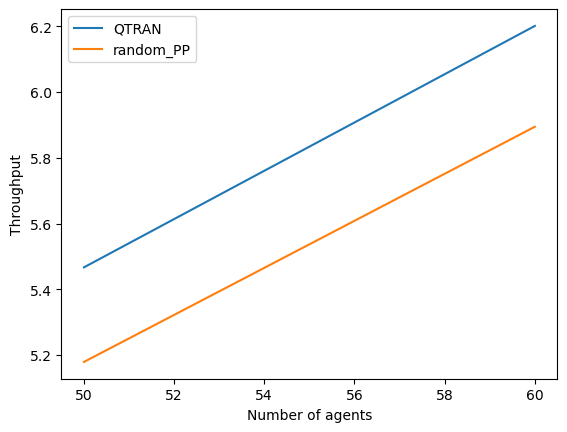

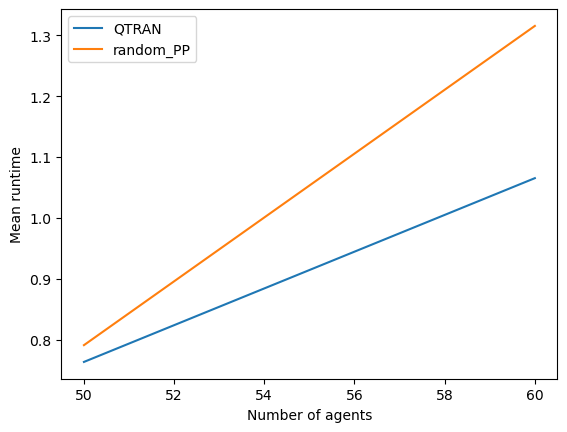

In [24]:
num_of_agents = list(range(50, 101, 10))
grid_map = "warehouse_2"

algorithm = "QTRAN"
# CONFIGS
config = config_file["generate_results"]
DIR = config["root"] + config["subroot"]
dir_results = DIR + algorithm + "/" + grid_map + "/"
with open(dir_results+"results.pkl", "rb") as f:
    results_QTRAN = pickle.load(f)

throughput_QTRAN = []
mean_runtime_QTRAN = []
for n_agents in num_of_agents:
    # if failed to solve all instances
    if len(results_QTRAN[n_agents]['num_goals_reached']) != TIMESTEP:
        throughput_QTRAN.append(np.nan)
        mean_runtime_QTRAN.append(np.nan)
        continue

    throughput_QTRAN.append(np.mean(results_QTRAN[n_agents]['num_goals_reached']))
    mean_runtime_QTRAN.append(np.mean(results_QTRAN[n_agents]['runtimes']))

algorithm = "random_PP"
# CONFIGS
config = config_file["generate_results"]
DIR = config["root"] + config["subroot"]
dir_results = DIR + algorithm + "/" + grid_map + "/"
with open(dir_results+"results.pkl", "rb") as f:
    results_random_PP = pickle.load(f)

throughput_random_PP = []
mean_runtime_random_PP = []
for n_agents in num_of_agents:
    # if failed to solve all instances
    if len(results_random_PP[n_agents]['num_goals_reached']) != TIMESTEP:
        throughput_random_PP.append(np.nan)
        mean_runtime_random_PP.append(np.nan)
        continue

    throughput_random_PP.append(np.mean(results_random_PP[n_agents]['num_goals_reached']))
    mean_runtime_random_PP.append(np.mean(results_random_PP[n_agents]['runtimes']))

# plot throughput and save
plt.plot(num_of_agents, throughput_QTRAN, label='QTRAN')
plt.plot(num_of_agents, throughput_random_PP, label='random_PP')
plt.xlabel('Number of agents')
plt.ylabel('Throughput')
plt.legend()
plt.savefig('throughput.png')
plt.show()

# plot mean runtime
plt.plot(num_of_agents, mean_runtime_QTRAN, label='QTRAN')
plt.plot(num_of_agents, mean_runtime_random_PP, label='random_PP')
plt.xlabel('Number of agents')
plt.ylabel('Mean runtime')
plt.legend()
plt.savefig('mean_runtime.png')
plt.show()


In [30]:
# increase in percentage between QTRAN and random_PP of each number of agents
np.round((np.array(throughput_QTRAN) - np.array(throughput_random_PP)) / np.array(throughput_random_PP) * 100, 3)

array([5.553, 5.202,   nan,   nan,   nan,   nan])

In [31]:
throughput_QTRAN, throughput_random_PP

([5.4668, 6.201, nan, nan, nan, nan], [5.1792, 5.8944, nan, nan, nan, nan])